# Multi-class Classification

I will work on a multi-class classification problem. I will be using the [Sign Language MNIST](https://www.kaggle.com/datamunge/sign-language-mnist) dataset, which contains 28x28 images of hands depicting the 26 letters of the English alphabet.

I will need to pre-process the data so that it can be fed into your convolutional neural network to correctly classify each image as the letter it represents.



In [31]:
# grader-required-cell

import csv
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

Download the training and test sets (the test set will actually be used as a validation set):

In [32]:
# sign_mnist_train.csv
!gdown --id 1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
# sign_mnist_test.csv
!gdown --id 1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
To: /content/sign_mnist_train.csv
100% 83.3M/83.3M [00:00<00:00, 182MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg
To: /content/sign_mnist_test.csv
100% 21.8M/21.8M [00:00<00:00, 212MB/s]


Define some globals with the path to both files you just downloaded:

In [33]:
# grader-required-cell

TRAINING_FILE = './sign_mnist_train.csv'
VALIDATION_FILE = './sign_mnist_test.csv'

Unlike previous assignments, you will not have the actual images provided, instead you will have the data serialized as `csv` files.

Take a look at how the data looks like within the `csv` file:

In [34]:
# grader-required-cell

with open(TRAINING_FILE) as training_file:
  line = training_file.readline()
  print(f"First line (header) looks like this:\n{line}")
  line = training_file.readline()
  print(f"Each subsequent line (data points) look like this:\n{line}")

First line (header) looks like this:
label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pix

As you can see, each file includes a header (the first line) and each subsequent data point is represented as a line that contains 785 values.

The first value is the label (the numeric representation of each letter) and the other 784 values are the value of each pixel of the image. Remember that the original images have a resolution of 28x28, which sums up to 784 pixels.

In [35]:
import csv
import numpy as np

def parse_data_from_input(filename):
    
    with open(filename) as file:
        csv_reader = csv.reader(file)

        # Skip the header row
        next(csv_reader)

        labels = []
        images = []

        for row in csv_reader:
            label = float(row[0])
            pixel_values = np.array(row[1:], dtype=np.float64)
            image = pixel_values.reshape(28, 28)  # Reshape to 28x28 image

            labels.append(label)
            images.append(image)

        labels = np.array(labels, dtype=np.float64)
        images = np.array(images, dtype=np.float64)

    return images, labels


In [36]:
# grader-required-cell

# Test your function
training_images, training_labels = parse_data_from_input(TRAINING_FILE)
validation_images, validation_labels = parse_data_from_input(VALIDATION_FILE)

print(f"Training images has shape: {training_images.shape} and dtype: {training_images.dtype}")
print(f"Training labels has shape: {training_labels.shape} and dtype: {training_labels.dtype}")
print(f"Validation images has shape: {validation_images.shape} and dtype: {validation_images.dtype}")
print(f"Validation labels has shape: {validation_labels.shape} and dtype: {validation_labels.dtype}")

Training images has shape: (27455, 28, 28) and dtype: float64
Training labels has shape: (27455,) and dtype: float64
Validation images has shape: (7172, 28, 28) and dtype: float64
Validation labels has shape: (7172,) and dtype: float64


## Visualizing the numpy arrays

Now that you have converted the initial csv data into a format that is compatible with computer vision tasks, take a moment to actually see how the images of the dataset look like:

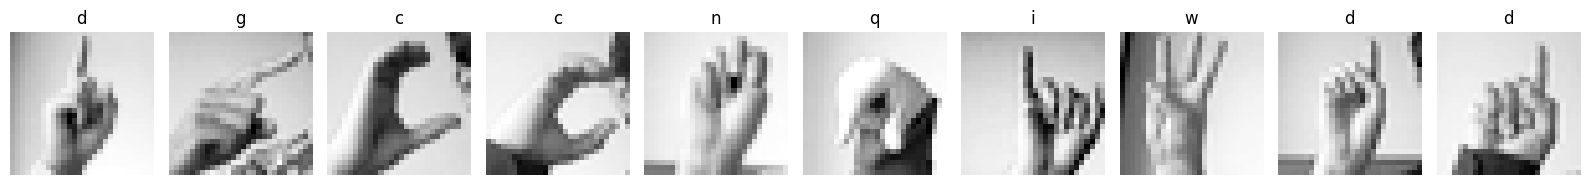

In [37]:
# Plot a sample of 10 images from the training set
def plot_categories(training_images, training_labels):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for k in range(10):
    img = training_images[k]
    img = np.expand_dims(img, axis=-1)
    img = array_to_img(img)
    ax = axes[k]
    ax.imshow(img, cmap="Greys_r")
    ax.set_title(f"{letters[int(training_labels[k])]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(training_images, training_labels)

In [62]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

def train_val_generators(training_images, training_labels, validation_images, validation_labels):
    
    # Add the "color" dimension (channel) to the images
    training_images = np.expand_dims(training_images, axis=-1)
    validation_images = np.expand_dims(validation_images, axis=-1)

    # Instantiate the ImageDataGenerator class for training data
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255.0,  # Normalize pixel values to the range [0, 1]
        rotation_range=10,    # Randomly rotate images by up to 10 degrees
        width_shift_range=0.1,  # Randomly shift images horizontally by up to 10%
        height_shift_range=0.1,  # Randomly shift images vertically by up to 10%
        shear_range=0.2,       # Shear intensity (shear angle in radians)
        zoom_range=0.2,        # Randomly zoom images by up to 20%
        horizontal_flip=True,  # Randomly flip images horizontally
        fill_mode='nearest'    # Fill in missing pixels with the nearest value
    )

    # Pass in the training data and labels to the flow method
    train_generator = train_datagen.flow(
        x=training_images,
        y=training_labels,  # Use integer labels here
        batch_size=32,  # Batch size for training
    )

    # Instantiate the ImageDataGenerator class for validation data
    validation_datagen = ImageDataGenerator(
        rescale=1.0 / 255.0  # Normalize pixel values to the range [0, 1]
    )

    # Pass in the validation data and labels to the flow method
    validation_generator = validation_datagen.flow(
        x=validation_images,
        y=validation_labels,  # Use integer labels here
        batch_size=32,  # Batch size for validation
    )

    return train_generator, validation_generator


In [58]:
# grader-required-cell

# Test your generators
train_generator, validation_generator = train_val_generators(training_images, training_labels, validation_images, validation_labels)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")

Images of training generator have shape: (27455, 28, 28, 1)
Labels of training generator have shape: (27455,)
Images of validation generator have shape: (7172, 28, 28, 1)
Labels of validation generator have shape: (7172,)


## Coding the CNN


This function will return a Keras' model that uses the `Sequential` or the `Functional` API.

The last layer of your model willa number of units equal to the number of letters in the English alphabet. It also use an activation function that will output the probabilities per letter.



In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import tensorflow as tf

def create_model():
    # Define the model using the Sequential API
    model = Sequential([
        # Convolutional layer 1
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D((2, 2)),

        # Convolutional layer 2
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        # Flatten the output for dense layers
        Flatten(),

        # Dense layer 1
        Dense(128, activation='relu'),

        # Output layer with units equal to the number of classes (excluding Z)
        Dense(25, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='rmsprop',  # You can choose other optimizers as well
                  loss='sparse_categorical_crossentropy',  # Suitable for integer labels
                  metrics=['accuracy'])  # Monitor accuracy during training

    return model

# Assuming you have already created train_generator and validation_generator

# Create the model
model = create_model()

# Train the model
history = model.fit(train_generator,
                    epochs=12,  # Adjust as needed
                    validation_data=validation_generator)


Epoch 1/12
858/858 [==============================] - 14s 15ms/step - loss: 2.2222 - accuracy: 0.3175 - val_loss: 1.1590 - val_accuracy: 0.6217
Epoch 2/12
858/858 [==============================] - 13s 15ms/step - loss: 1.1625 - accuracy: 0.6232 - val_loss: 0.6613 - val_accuracy: 0.7475
Epoch 3/12
858/858 [==============================] - 13s 15ms/step - loss: 0.7576 - accuracy: 0.7532 - val_loss: 0.4309 - val_accuracy: 0.8498
Epoch 4/12
858/858 [==============================] - 13s 15ms/step - loss: 0.5578 - accuracy: 0.8148 - val_loss: 0.2745 - val_accuracy: 0.9038
Epoch 5/12
858/858 [==============================] - 13s 15ms/step - loss: 0.4292 - accuracy: 0.8613 - val_loss: 0.1821 - val_accuracy: 0.9430
Epoch 6/12
858/858 [==============================] - 13s 15ms/step - loss: 0.3348 - accuracy: 0.8896 - val_loss: 0.1039 - val_accuracy: 0.9750
Epoch 7/12
858/858 [==============================] - 13s 15ms/step - loss: 0.2736 - accuracy: 0.9115 - val_loss: 0.0918 - val_accuracy:

Now take a look at your training history:

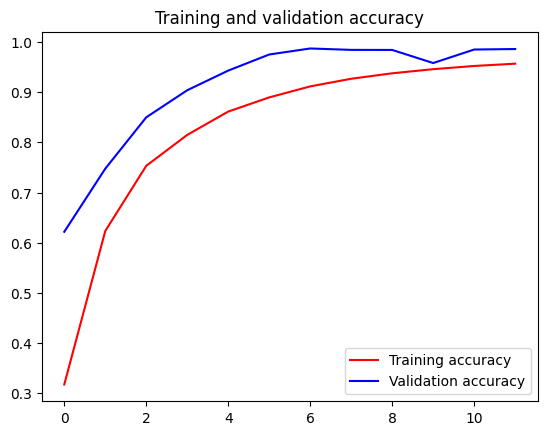

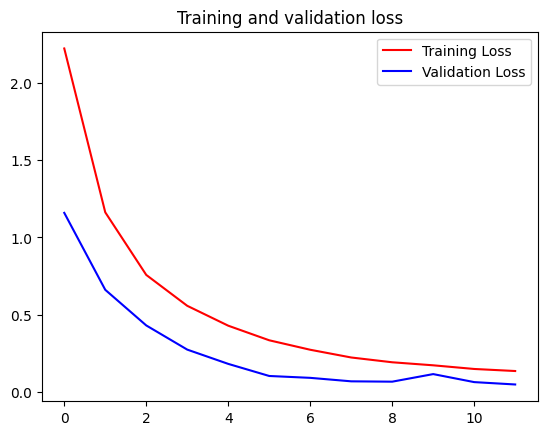

In [68]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [69]:
# Download metadata checker
!wget -nc https://storage.googleapis.com/tensorflow-1-public/colab_metadata_checker.py

--2023-09-28 07:32:34--  https://storage.googleapis.com/tensorflow-1-public/colab_metadata_checker.py
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.207, 142.250.107.207, 74.125.142.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1997 (2.0K) [text/x-python-script]
Saving to: ‘colab_metadata_checker.py’

colab_metadata_chec 100%[===================>]   1.95K  --.-KB/s    in 0s      

2023-09-28 07:32:34 (50.6 MB/s) - ‘colab_metadata_checker.py’ saved [1997/1997]



In [70]:
import colab_metadata_checker

# Please see the output of this cell to see which file you need to submit to the grader
colab_metadata_checker.run('C2W4_Assignment_fixed.ipynb')

Grader metadata detected! You can download this notebook by clicking `File > Download > Download as .ipynb` and submit it to the grader!
